# Etap 2

In [10]:
import pandas as pd
import numpy as np
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier


In [21]:
data = pd.read_csv('../Data/our_data.csv')

In [60]:
X = data.drop('Class', axis=1)
y = data['Class']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.3, random_state=42
)

# ENCODING

In [61]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_train.to_frame())
y_encoded = pd.DataFrame(enc.transform(y_train.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))
y_val_encoded = pd.DataFrame(enc.transform(y_val.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))
y_test_encoded = pd.DataFrame(enc.transform(y_test.to_frame()).toarray(),columns=enc.get_feature_names(['Class']))


/Users/mateuszdeptuch/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/mateuszdeptuch/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/mateuszdeptuch/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Usuwanie kolumn

In [62]:
# delete columns: ShapeFactor2,ShapeFactor4, Solidity, Extent 
X_train = X_train.drop(['Compactness','EquivDiameter', 'ConvexArea'], axis=1)
X_val = X_val.drop(['Compactness','EquivDiameter','ConvexArea'], axis=1)
X_test = X_test.drop(['Compactness','EquivDiameter','ConvexArea'], axis=1)
X_train


,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,Extent,Solidity,roundness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
4990,35815,713.667,269.737175,169.911449,1.587516,0.776664,0.726972,0.988655,0.883657,0.007531,0.001825,0.626749,0.994974
3361,37430,699.619,245.261315,194.850379,1.258716,0.607316,0.736898,0.991733,0.960963,0.006553,0.002537,0.792268,0.997240
10806,27915,622.004,234.701977,151.590536,1.548263,0.763435,0.701823,0.989578,0.906695,0.008408,0.002159,0.645230,0.998985
9320,56606,933.430,372.871747,193.926138,1.922751,0.854113,0.729318,0.987509,0.816411,0.006587,0.001092,0.518386,0.996728
6645,61336,986.354,381.651865,206.700620,1.846399,0.840640,0.647708,0.983201,0.792245,0.006222,0.001103,0.536156,0.989957
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2219,44318,800.556,302.124686,187.628402,1.610229,0.783787,0.690247,0.988270,0.868974,0.006817,0.001607,0.618184,0.995418
758,32015,653.676,212.929989,191.810135,1.110108,0.434207,0.761881,0.988880,0.941539,0.006651,0.003316,0.899063,0.998057
7089,84154,1169.542,416.682290,258.039787,1.614799,0.785176,0.757482,0.984338,0.773131,0.004951,0.001163,0.617127,0.996536
8185,33104,687.923,259.570383,162.678572,1.595603,0.779243,0.745132,0.985561,0.879044,0.007841,0.001893,0.625576,0.998171


## Normalizacja

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
X_train = scaling.fit_transform(X_train)
X_test = scaling.transform(X_test)
X_val = scaling.transform(X_val)

array([[0.06573554, 0.12934863, 0.15512763, ..., 0.42787912, 0.66382829,
        0.37661018],
       [0.07263147, 0.11973088, 0.11104755, ..., 0.71570976, 0.52472281,
        0.67309654],
       [0.03200311, 0.066593  , 0.09203059, ..., 0.4617662 , 0.78836283,
        0.40971407],
       ...,
       [0.27213958, 0.44145624, 0.41977011, ..., 0.4100392 , 0.29719209,
        0.35937584],
       [0.05415976, 0.1117234 , 0.13681763, ..., 0.42571264, 0.707833  ,
        0.37451014],
       [0.07910041, 0.14293314, 0.1539674 , ..., 0.53271051, 0.57545976,
        0.48057632]])

## Feature importance

Ranking cech: 
Cecha MinorAxisLength (0.12615890157936022)
Cecha ShapeFactor1 (0.11442374111145348)
Cecha Perimeter (0.10394894158777068)
Cecha MajorAxisLength (0.09956325874365198)
Cecha ShapeFactor3 (0.09879126020664408)
Cecha Eccentricity (0.09656949284669879)
Cecha Area (0.09584664029436968)
Cecha AspectRation (0.08774366627774427)
Cecha ShapeFactor2 (0.06306038595503966)
Cecha roundness (0.05709862437707408)
Cecha ShapeFactor4 (0.03291219233573339)
Cecha Solidity (0.015850396966212432)
Cecha Extent (0.008032497718247418)


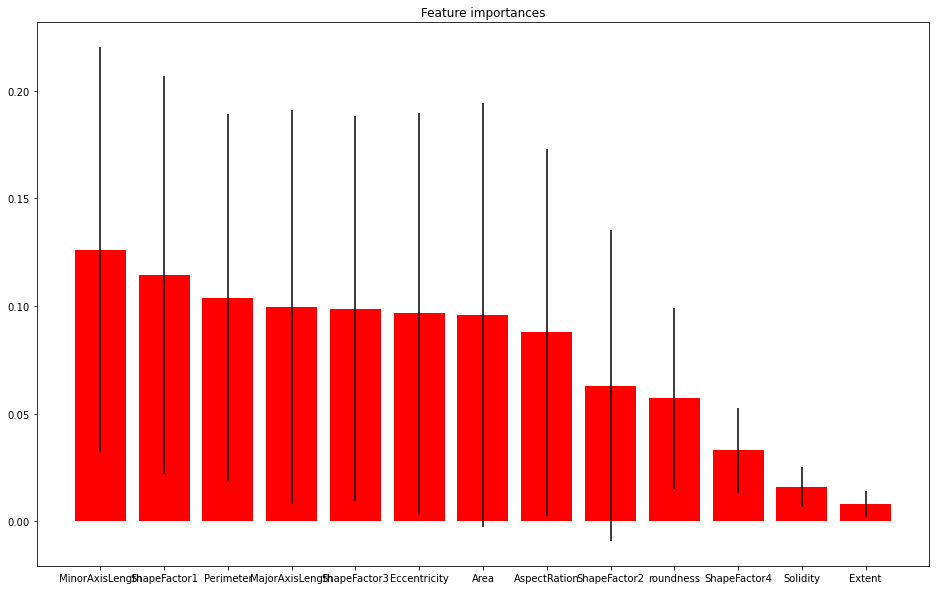

In [63]:
clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
clf.fit(X_train, y_train)

feature_importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
indices = np.argsort(feature_importances)[::-1]



print("Ranking cech: ")
for i in range(X_train.shape[1]):
    print(f"Cecha {X_train.columns[indices[i]]} ({feature_importances[indices[i]]})")

plt.figure(figsize=(16,10))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [64]:
#delete Extent and Solidity
X_train = X_train.drop(['Extent','Solidity'], axis=1)
X_val = X_val.drop(['Extent','Solidity'], axis=1)
X_test = X_test.drop(['Extent','Solidity'], axis=1)

# kodzenie

In [65]:
#tu encodowane dane dają błąd 
from sklearn.svm import SVC
svm = SVC(kernel='linear', C=1, random_state=42, decision_function_shape='ovo').fit(X_train, y_train)
print("SVM accuracy: {:.2f}".format(svm.score(X_val, y_val)))
print("SVM f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val, svm.predict(X_val), average='weighted')))
#uwaga na zmiane parametrow bo moze sie robic kilka dni

SVM accuracy: 0.92
SVM f1 score: 0.92

In [44]:
#tree
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=10000, random_state=42)
tree.fit(X_train, y_encoded)
y_hat = tree.predict(X_val)
print("Tree accuracy: {:.2f}".format(tree.score(X_val, y_val_encoded)))
print("Tree f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded, y_hat, average='weighted')))

Tree accuracy: 0.89
Tree f1 score: 0.89


Tree accuracy: 0.89  
Tree f1 score: 0.89

In [45]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth=10000, random_state=42, criterion='entropy')
tree.fit(X_train, y_encoded)
y_hat = tree.predict(X_val)
print("Tree accuracy: {:.2f}".format(tree.score(X_val, y_val_encoded)))
print("Tree f1 score: {:.2f}".format(sklearn.metrics.f1_score(y_val_encoded, y_hat, average='weighted')))

Tree accuracy: 0.89
Tree f1 score: 0.89


In [50]:
#random forest
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train, y_encoded)
y_hat = forest.predict(X_val)
print("Forest accuracy: {:.2f}".format(forest.score(X_val, y_val_encoded)))

Forest accuracy: 0.90
